In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from tqdm import tqdm
from joblib import Parallel, delayed

from simulation import *

In [3]:
elo_settings = EloSettings(K=20)
simulator = Simulator(elo_settings=elo_settings)

In [4]:
# Run Monte-Carlo simulations
num_sims = 100000

pos_history = np.zeros((num_sims, simulator.num_teams), dtype=np.int8)
pos_history_mask = np.ones(num_sims, dtype=np.int8)

simulated_games_res = np.zeros((num_sims, simulator.tbp_mat.sum()), dtype=np.int8)

for sim_idx in tqdm(range(num_sims)):
    try:
        sim_wins, sim_point_diff, sim_games = simulator.simulate_rounds(simulator.base_elo, 
                                  start_round=simulator.last_played_round+1,
                                  record_simulated_games=True, partial_round=True)
        order = get_order(np.arange(18), wins_mat=sim_wins, point_diff_mat=sim_point_diff)
        # simulator.team_encoder.inverse_transform(order)
        pos_history[sim_idx, np.flip(order)] = np.arange(simulator.num_teams) + 1
        simulated_games_res[sim_idx, :] = sim_games[simulator.tbp_mat]
    except Exception as e:
        pos_history_mask[sim_idx] = 0

pos_history = pos_history[pos_history_mask==1]

100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [00:53<00:00, 1865.66it/s]


In [5]:
# def run_montecarlo(sim_idx):
#     sim_wins, sim_point_diff = simulator.simulate_rounds(simulator.base_elo, 
#                               start_round=simulator.last_played_round+1)
#     order = get_order(np.arange(18), wins_mat=sim_wins, point_diff_mat=sim_point_diff)
#     # simulator.team_encoder.inverse_transform(order)
#     pos_history[sim_idx, np.flip(order)] = np.arange(simulator.num_teams) + 1


# num_sims = 10000
# pos_history = np.zeros((num_sims, simulator.num_teams), dtype=np.int8)

# tic = time.time()
# Parallel(n_jobs=4)(delayed(run_montecarlo)(sim_idx) for sim_idx in range(num_sims))
# toc = time.time()

# print(toc - tic)

# Probability Table Visualization

In [6]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap

import seaborn as sns
import pandas as pd

In [7]:
probs = (np.repeat(pos_history[:, :, np.newaxis], simulator.num_teams, axis=2) == np.arange(1, 19)).mean(axis=0)
probs = np.concatenate([probs[:, :8].sum(axis=1)[:, np.newaxis], probs], axis=1)

plot_standings = pos_history.mean(axis=0).argsort()
prob_df = pd.DataFrame(probs[plot_standings, :]*100, index=[f'{v}  {i+1}' for i,v in enumerate(simulator.team_encoder.inverse_transform(plot_standings))], columns=['PO']+list(np.arange(1, 19)))

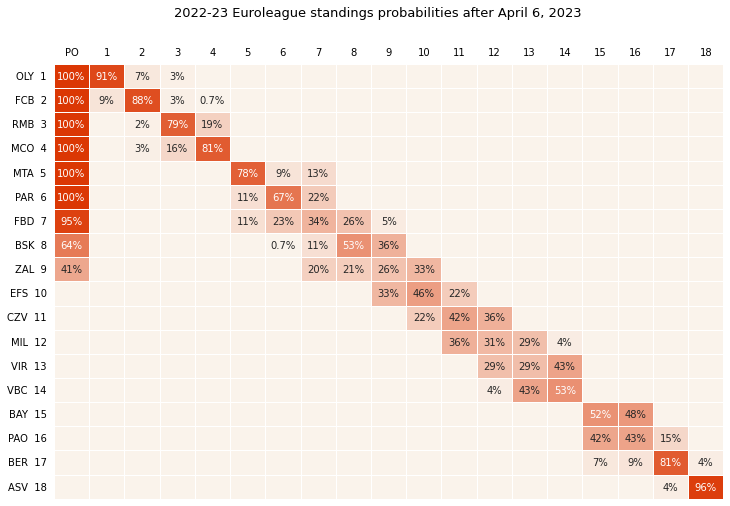

In [8]:
mask = np.round(probs[plot_standings, :]*100).astype(int) == 0

def custom_annot(data):
    result = np.empty_like(data, dtype=object)
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            if data[i, j] >= 1:
                result[i, j] = f"{data[i, j]:.0f}%"
            elif data[i, j] >= 0.1:
                result[i, j] = f"{data[i, j]:.1f}%"
            else:
                result[i, j] = "< 0.1%"
    
    return result

# create custom colormap
cmap = LinearSegmentedColormap.from_list('my_cmap', ['#faf3eb', '#db3704'])
cmap.set_bad("#faf3eb")

sns.heatmap(prob_df, cmap=cmap, annot=custom_annot(probs[plot_standings, :]*100), fmt='',
            linewidths=1, linecolor='white', square=False,
            cbar=False, mask=mask)

plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True, left=False)

plt.gcf().set_size_inches(12, 8)
plt.suptitle('2022-23 Euroleague standings probabilities after April 6, 2023', 
             fontsize=13);

# plt.savefig('prob_tables_r33_thurs.png', dpi=200, facecolor='white')